In [1]:
import pandas as pd


In [2]:
nuts = pd.read_csv("NUTS_AT_2016.csv")

nuts.head()


,CNTR_CODE,NUTS_ID,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE
0,UK,UKL2,East Wales,East Wales,0,0,0
1,UK,UKL18,Swansea,Swansea,4,1,1
2,UK,UKL17,Bridgend and Neath Port Talbot,Bridgend and Neath Port Talbot,2,1,1
3,UK,UKL16,Gwent Valleys,Gwent Valleys,2,1,2
4,UK,UKL15,Central Valleys,Central Valleys,3,1,2


In [3]:
nuts["nuts_level"] = nuts["NUTS_ID"].str.len()


In [4]:
nuts[["NUTS_ID", "nuts_level"]].head(10)


,NUTS_ID,nuts_level
0,UKL2,4
1,UKL18,5
2,UKL17,5
3,UKL16,5
4,UKL15,5
5,UKL14,5
6,UKL12,5
7,UKL11,5
8,UKL1,4
9,UKL,3


In [5]:
nuts2_country_map = (
    nuts
    .query("nuts_level == 4")
    [["NUTS_ID", "CNTR_CODE"]]
    .rename(columns={
        "NUTS_ID": "nuts2",
        "CNTR_CODE": "country"
    })
)


In [6]:
nuts2_country_map = nuts2_country_map[
    nuts2_country_map["country"] != "UK"
]


In [7]:
nuts2_country_map["nuts2"].str.len().value_counts()


nuts2
4    291
Name: count, dtype: int64

In [8]:
import pandas as pd
import numpy as np

energy = pd.read_csv("energy_mix_ece_country_year.csv")
energy.head()


,geo,year,fuel_group,value,total_energy,share
0,BG,1990,electricity,268303.0,4908946.0,0.054656
1,BG,1990,gas,1939661.0,4908946.0,0.395128
2,BG,1990,oil,661852.0,4908946.0,0.134826
3,BG,1990,renewables_other,50781.0,4908946.0,0.010345
4,BG,1990,solid_fossil,586475.0,4908946.0,0.119471


In [9]:
energy = energy.rename(columns={"geo": "country"})
energy["country"].unique()[:10], energy.shape


(array(['BG', 'CZ', 'EE', 'HR', 'HU', 'LT', 'LV', 'PL', 'RO', 'SI'],
       dtype=object),
 (2365, 6))

In [10]:
# 1) Scoatem electricity (vector energetic, nu sursă primară)
energy_no_elec = energy[energy["fuel_group"] != "electricity"].copy()

# 2) Grupăm renewables_other + biomass într-o singură categorie "renewables"
energy_no_elec["fuel_group_clean"] = energy_no_elec["fuel_group"].replace({
    "renewables_other": "renewables",
    "biomass": "renewables"
})

energy_no_elec["fuel_group_clean"].value_counts()


fuel_group_clean
renewables      440
gas             385
oil             385
solid_fossil    385
solid_fuels     385
Name: count, dtype: int64

In [11]:
# Recalculează totalul (pe combustibili excluzând electricity)
energy_no_elec["total_fuels"] = (
    energy_no_elec
    .groupby(["country", "year"])["value"]
    .transform("sum")
)

# Share nou (corect pentru mixul de combustibili)
energy_no_elec["share_fuels"] = energy_no_elec["value"] / energy_no_elec["total_fuels"]

# Sanity check: share-urile să însumeze ~1 pe country-year
check = (energy_no_elec.groupby(["country","year"])["share_fuels"].sum().round(6))
check.describe()


count    385.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: share_fuels, dtype: float64

In [12]:
energy_clean = (
    energy_no_elec
    .groupby(["country", "year", "fuel_group_clean"], as_index=False)
    .agg(value=("value","sum"),
         share_fuels=("share_fuels","sum"))
)

energy_clean.head()


,country,year,fuel_group_clean,value,share_fuels
0,BG,1990,gas,1939661.0,0.417972
1,BG,1990,oil,661852.0,0.142621
2,BG,1990,renewables,50781.0,0.010943
3,BG,1990,solid_fossil,586475.0,0.126378
4,BG,1990,solid_fuels,1401874.0,0.302086


In [13]:
energy_wide = (
    energy_clean
    .pivot_table(index=["country", "year"],
                 columns="fuel_group_clean",
                 values="share_fuels",
                 aggfunc="sum")
    .reset_index()
)

energy_wide.head()


fuel_group_clean,country,year,gas,oil,renewables,solid_fossil,solid_fuels
0,BG,1990,0.417972,0.142621,0.010943,0.126378,0.302086
1,BG,1991,0.430574,0.113118,0.010445,0.136123,0.309740
2,BG,1992,0.428022,0.108317,0.013657,0.156896,0.293108
3,BG,1993,0.418344,0.131912,0.012731,0.161013,0.276000
4,BG,1994,0.439292,0.134601,0.014348,0.155435,0.256324


In [14]:
energy_wide = energy_wide.fillna(0)

energy_wide["fossil_share"] = (
    energy_wide.get("gas", 0)
    + energy_wide.get("oil", 0)
    + energy_wide.get("solid_fossil", 0)
)

energy_wide["renewable_share"] = energy_wide.get("renewables", 0)
energy_wide["coal_share"] = energy_wide.get("solid_fossil", 0)

energy_wide[["fossil_share","renewable_share","coal_share"]].describe()


fuel_group_clean,fossil_share,renewable_share,coal_share
count,385.000000,385.000000,385.000000
mean,0.694710,0.177702,0.078390
std,0.137263,0.125057,0.069235
min,0.149826,0.010445,0.000276
25%,0.643954,0.091827,0.009102
50%,0.725290,0.154534,0.062055
75%,0.784691,0.228928,0.123564
max,0.920157,0.828011,0.252911


In [15]:
(energy_wide["fossil_share"] + energy_wide["renewable_share"]).describe()


count    385.000000
mean       0.872412
std        0.075882
min        0.545939
25%        0.843311
50%        0.884716
75%        0.929548
max        0.977837
dtype: float64

In [16]:
energy_nuts2 = nuts2_country_map.merge(energy_wide, on="country", how="left")
energy_nuts2.head()


,nuts2,country,year,gas,oil,renewables,solid_fossil,solid_fuels,fossil_share,renewable_share,coal_share
0,FRB0,FR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FRC1,FR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FRC2,FR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FRD1,FR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FRD2,FR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
energy_nuts2.duplicated(subset=["nuts2","year"]).mean()


np.float64(0.0)

In [18]:
countries_energy = energy_wide["country"].unique()

nuts2_country_map_ece = nuts2_country_map[
    nuts2_country_map["country"].isin(countries_energy)
].copy()

nuts2_country_map_ece.shape


(59, 2)

In [19]:
energy_nuts2 = nuts2_country_map_ece.merge(
    energy_wide,
    on="country",
    how="left"
)

energy_nuts2.head()


,nuts2,country,year,gas,oil,renewables,solid_fossil,solid_fuels,fossil_share,renewable_share,coal_share
0,RO32,RO,1990,0.737559,0.092289,0.012125,0.050911,0.107115,0.880759,0.012125,0.050911
1,RO32,RO,1991,0.733551,0.087830,0.017632,0.051606,0.109380,0.872987,0.017632,0.051606
2,RO32,RO,1992,0.616183,0.072372,0.020191,0.052778,0.238475,0.741334,0.020191,0.052778
3,RO32,RO,1993,0.602672,0.072334,0.025380,0.054343,0.245270,0.729350,0.025380,0.054343
4,RO32,RO,1994,0.671228,0.085522,0.031513,0.062759,0.148978,0.819509,0.031513,0.062759


In [20]:
energy_nuts2.duplicated(subset=["nuts2", "year"]).mean()


np.float64(0.0)

In [21]:
energy_nuts2[["gas", "oil"]].isna().mean()


gas    0.0
oil    0.0
dtype: float64

In [22]:
energy_nuts2 = energy_nuts2.fillna(0)

energy_nuts2["fossil_share"] = (
    energy_nuts2.get("gas", 0)
    + energy_nuts2.get("oil", 0)
    + energy_nuts2.get("solid_fossil", 0)
)

energy_nuts2["renewable_share"] = energy_nuts2.get("renewables", 0)
energy_nuts2["coal_share"] = energy_nuts2.get("solid_fossil", 0)

energy_nuts2[["fossil_share","renewable_share","coal_share"]].describe()


,fossil_share,renewable_share,coal_share
count,2065.000000,2065.000000,2065.000000
mean,0.738305,0.134700,0.112090
std,0.096557,0.095374,0.073284
min,0.149826,0.010445,0.000276
25%,0.707788,0.079543,0.048486
50%,0.748244,0.122851,0.108838
75%,0.788329,0.167730,0.176126
max,0.920157,0.828011,0.252911


In [23]:
energy_nuts2.to_csv("energy_NUTS2_assigned.csv", index=False)


In [24]:
emissions = pd.read_csv("Emissions_NUTS2.csv")
emissions.head()


,Substance,ISO,Country,NUTS 2,NUTS 2 desc,Sector,Year,Emissions
0,CO2,AUT,Austria,AT,NaN,Dom_Avi,1990,64.581186
1,CO2,AUT,Austria,AT,NaN,Dom_Avi,1991,70.729954
2,CO2,AUT,Austria,AT,NaN,Dom_Avi,1992,73.804646
3,CO2,AUT,Austria,AT,NaN,Dom_Avi,1993,86.102502
4,CO2,AUT,Austria,AT,NaN,Dom_Avi,1994,92.251572


In [26]:
print("emissions columns:", emissions.columns.tolist())
print("energy_nuts2 columns:", energy_nuts2.columns.tolist())


emissions columns: ['Substance', 'ISO', 'Country', 'NUTS 2', 'NUTS 2 desc', 'Sector', 'Year', 'Emissions']
energy_nuts2 columns: ['nuts2', 'country', 'year', 'gas', 'oil', 'renewables', 'solid_fossil', 'solid_fuels', 'fossil_share', 'renewable_share', 'coal_share']


In [27]:
emissions.columns.tolist()

['Substance',
 'ISO',
 'Country',
 'NUTS 2',
 'NUTS 2 desc',
 'Sector',
 'Year',
 'Emissions']

In [28]:
emissions.columns = emissions.columns.str.strip()
emissions.columns


Index(['Substance', 'ISO', 'Country', 'NUTS 2', 'NUTS 2 desc', 'Sector',
       'Year', 'Emissions'],
      dtype='object')

In [29]:
emissions = emissions.rename(columns={
    "NUTS 2": "nuts2",
    "Year": "year",
    "Emissions": "co2_energy"
})


In [30]:
emissions[["nuts2","year","co2_energy"]].head()


,nuts2,year,co2_energy
0,AT,1990,64.581186
1,AT,1991,70.729954
2,AT,1992,73.804646
3,AT,1993,86.102502
4,AT,1994,92.251572


In [31]:
emissions["Sector"].value_counts()


Sector
Industry       8192
Buildings      7953
Transport      7854
Energy         7722
Agriculture    7551
Waste          5403
Dom_Avi         855
Dom_Ship        835
Name: count, dtype: int64

In [32]:
emissions_energy = emissions[
    emissions["Sector"].str.contains("energy", case=False, na=False)
].copy()


In [33]:
emissions_energy = emissions_energy[
    emissions_energy["Substance"].str.contains("CO2", case=False, na=False)
]


In [34]:
# coduri NUTS2 valide?
emissions_energy["nuts2"].str.len().value_counts()

# ani disponibili
emissions_energy["year"].min(), emissions_energy["year"].max()

# dubluri?
emissions_energy.duplicated(subset=["nuts2","year"]).mean()


np.float64(0.0)

In [35]:
final_df = emissions_energy.merge(
    energy_nuts2,
    on=["nuts2","year"],
    how="left",
    validate="m:1"
)

final_df.head()


,Substance,ISO,Country,nuts2,NUTS 2 desc,Sector,year,co2_energy,country,gas,oil,renewables,solid_fossil,solid_fuels,fossil_share,renewable_share,coal_share
0,CO2,AUT,Austria,AT11,Burgenland,Energy,1990,240.746162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CO2,AUT,Austria,AT11,Burgenland,Energy,1991,264.931007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CO2,AUT,Austria,AT11,Burgenland,Energy,1992,272.857652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CO2,AUT,Austria,AT11,Burgenland,Energy,1993,289.490577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CO2,AUT,Austria,AT11,Burgenland,Energy,1994,314.739180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
final_df.duplicated(subset=["nuts2","year"]).mean()


np.float64(0.0)

In [37]:
final_df.to_csv("CEE_NUTS2_energy_emissions_panel.csv", index=False)


# Dinamici energetice

In [38]:
final_df = final_df.sort_values(["nuts2","year"])

final_df["co2_growth"] = (
    final_df.groupby("nuts2")["co2_energy"].pct_change()
)

final_df["delta_renewables"] = (
    final_df.groupby("nuts2")["renewable_share"].diff()
)

final_df["delta_coal"] = (
    final_df.groupby("nuts2")["coal_share"].diff()
)


In [39]:
final_df["coal_lockin"] = (
    final_df.groupby("nuts2")["coal_share"].cumsum()
)


In [40]:
import numpy as np

def slope(x):
    return np.polyfit(range(len(x)), x, 1)[0]

trends = (
    final_df.groupby("nuts2")["co2_energy"]
    .apply(slope)
    .rename("co2_trend")
)


In [41]:
final_df.describe()
final_df.groupby("year")["co2_energy"].mean()
final_df.groupby("nuts2").size().describe()


count    234.0
mean      33.0
std        0.0
min       33.0
25%       33.0
50%       33.0
75%       33.0
max       33.0
dtype: float64

In [43]:
 final_df.head()

,Substance,ISO,Country,nuts2,NUTS 2 desc,Sector,year,co2_energy,country,gas,...,renewables,solid_fossil,solid_fuels,fossil_share,renewable_share,coal_share,co2_growth,delta_renewables,delta_coal,coal_lockin
0,CO2,AUT,Austria,AT11,Burgenland,Energy,1990,240.746162,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CO2,AUT,Austria,AT11,Burgenland,Energy,1991,264.931007,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.100458,NaN,NaN,NaN
2,CO2,AUT,Austria,AT11,Burgenland,Energy,1992,272.857652,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.029920,NaN,NaN,NaN
3,CO2,AUT,Austria,AT11,Burgenland,Energy,1993,289.490577,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.060958,NaN,NaN,NaN
4,CO2,AUT,Austria,AT11,Burgenland,Energy,1994,314.739180,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.087217,NaN,NaN,NaN


In [44]:
final_df.columns

Index(['Substance', 'ISO', 'Country', 'nuts2', 'NUTS 2 desc', 'Sector', 'year',
       'co2_energy', 'country', 'gas', 'oil', 'renewables', 'solid_fossil',
       'solid_fuels', 'fossil_share', 'renewable_share', 'coal_share',
       'co2_growth', 'delta_renewables', 'delta_coal', 'coal_lockin'],
      dtype='object')

In [45]:
final_df["Sector"].value_counts().head(20)


Sector
Energy    7722
Name: count, dtype: int64

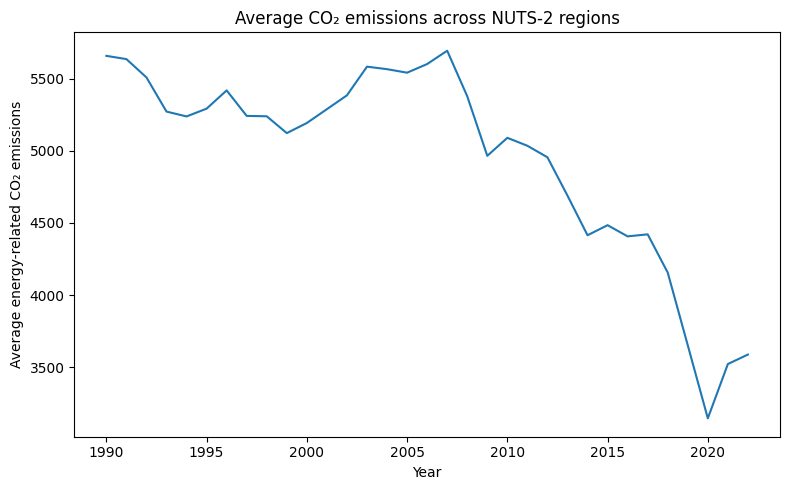

In [47]:
traj_all = (
    final_df
    .groupby("year")["co2_energy"]
    .mean()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(traj_all.index, traj_all.values)
plt.xlabel("Year")
plt.ylabel("Average energy-related CO₂ emissions")
plt.title("Average CO₂ emissions across NUTS-2 regions")
plt.tight_layout()
plt.show()


In [48]:
ece_countries = [
    "BG",  # Bulgaria
    "CZ",  # Czechia
    "EE",  # Estonia
    "HR",  # Croatia
    "HU",  # Hungary
    "LT",  # Lithuania
    "LV",  # Latvia
    "PL",  # Poland
    "RO",  # Romania
    "SI",  # Slovenia
    "SK",  # Slovakia
    "AT"   # Austria (ECE extins / Central Europe)
]


In [49]:
final_df_ece = final_df[
    final_df["ISO"].isin(ece_countries)
].copy()


In [50]:
final_df_ece["ISO"].value_counts().sort_index()


Series([], Name: count, dtype: int64)

In [51]:
final_df_ece.groupby("nuts2").size().describe()


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64

In [52]:
ece_prefixes = [
    "BG", "CZ", "EE", "HR", "HU",
    "LT", "LV", "PL", "RO", "SI",
    "SK", "AT"
]

final_df_ece = final_df[
    final_df["nuts2"].str[:2].isin(ece_prefixes)
].copy()


In [53]:
final_df_ece.groupby("nuts2").size().describe()


count    68.0
mean     33.0
std       0.0
min      33.0
25%      33.0
50%      33.0
75%      33.0
max      33.0
dtype: float64

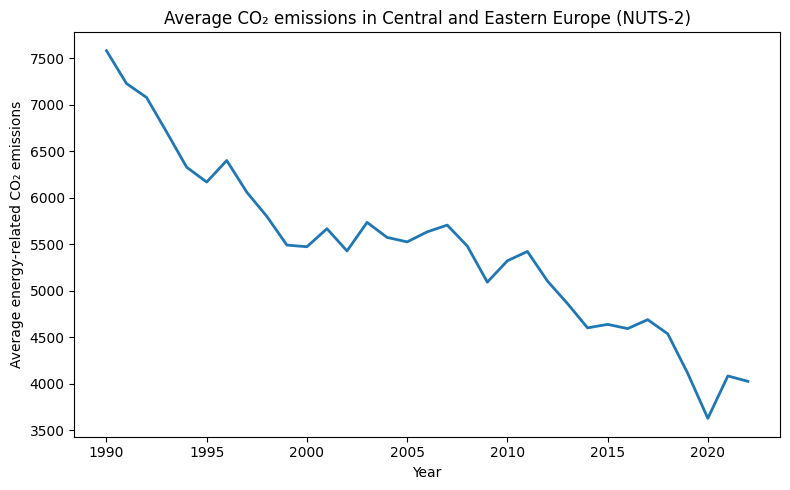

In [55]:
traj_ece = (
    final_df_ece
    .groupby("year")["co2_energy"]
    .mean()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(traj_ece.index, traj_ece.values, linewidth=2)
plt.xlabel("Year")
plt.ylabel("Average energy-related CO₂ emissions")
plt.title("Average CO₂ emissions in Central and Eastern Europe (NUTS-2)")
plt.tight_layout()
plt.show()


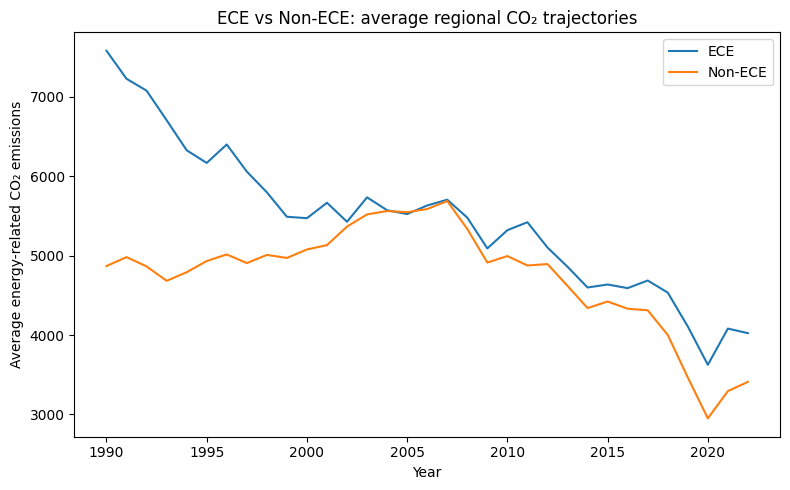

In [56]:
final_df["region_group"] = final_df["nuts2"].str[:2].apply(
    lambda x: "ECE" if x in ece_prefixes else "Non-ECE"
)

traj_compare = (
    final_df
    .groupby(["region_group","year"])["co2_energy"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
for g in ["ECE","Non-ECE"]:
    sub = traj_compare[traj_compare["region_group"] == g]
    plt.plot(sub["year"], sub["co2_energy"], label=g)

plt.xlabel("Year")
plt.ylabel("Average energy-related CO₂ emissions")
plt.title("ECE vs Non-ECE: average regional CO₂ trajectories")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\osaci\AppData\Local\Temp\ipykernel_41772\2596037165.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


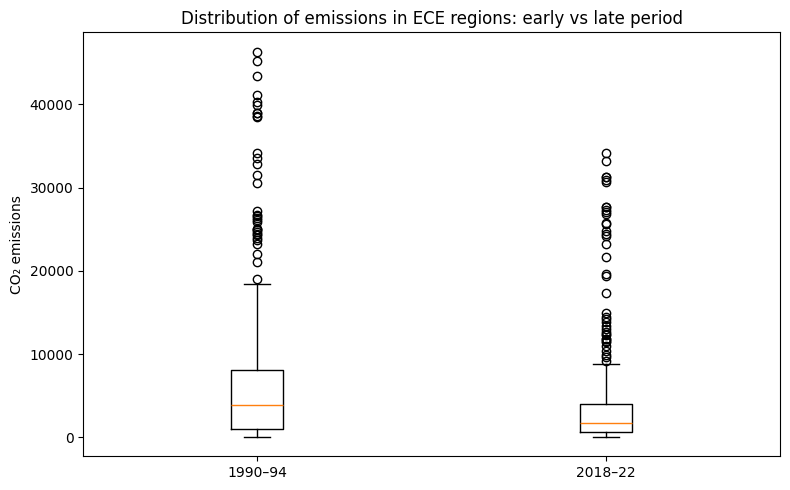

In [57]:
early_ece = final_df_ece[final_df_ece["year"].between(1990,1994)]
late_ece  = final_df_ece[final_df_ece["year"].between(2018,2022)]

plt.figure(figsize=(8,5))
plt.boxplot(
    [early_ece["co2_energy"], late_ece["co2_energy"]],
    labels=["1990–94","2018–22"]
)
plt.ylabel("CO₂ emissions")
plt.title("Distribution of emissions in ECE regions: early vs late period")
plt.tight_layout()
plt.show()


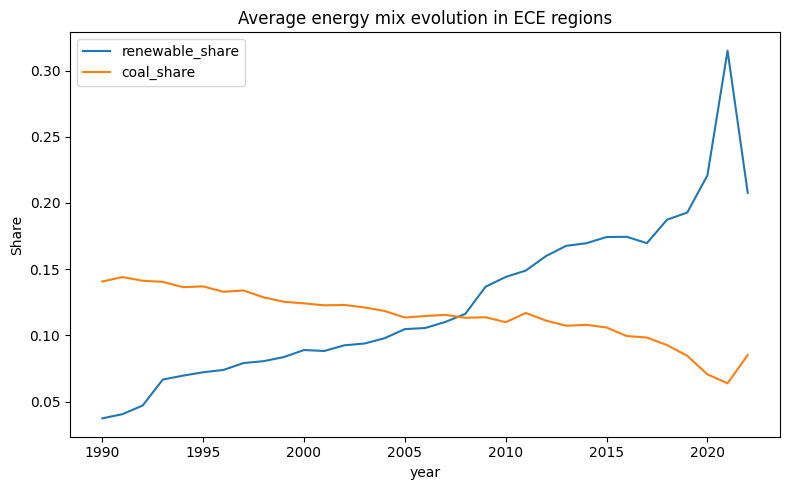

In [58]:
energy_ece = (
    final_df_ece
    .groupby("year")[["renewable_share","coal_share"]]
    .mean()
)

energy_ece.plot(figsize=(8,5))
plt.title("Average energy mix evolution in ECE regions")
plt.ylabel("Share")
plt.tight_layout()
plt.show()


In [59]:
final_df_ece.to_csv(
    "CEE_NUTS2_energy_emissions_panel_ECE.csv",
    index=False
)


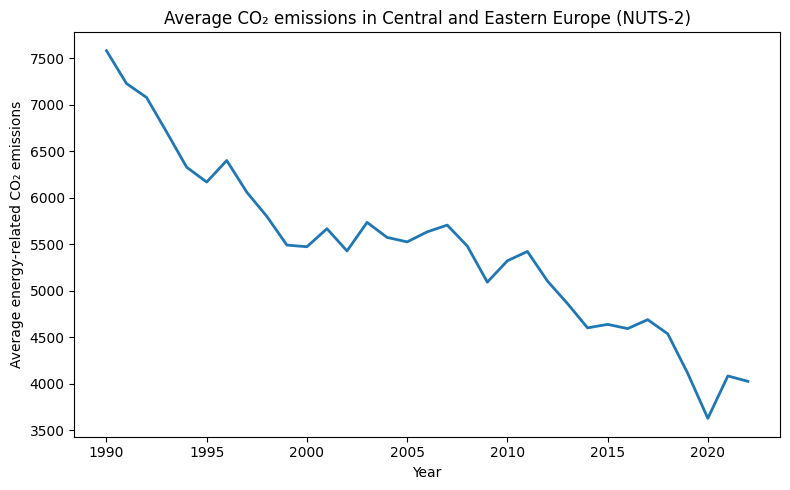

In [60]:
plt.figure(figsize=(8,5))
plt.plot(traj_ece.index, traj_ece.values, linewidth=2)
plt.xlabel("Year")
plt.ylabel("Average energy-related CO₂ emissions")
plt.title("Average CO₂ emissions in Central and Eastern Europe (NUTS-2)")
plt.tight_layout()

plt.savefig("fig_ECE_CO2_timeseries.png", dpi=300)
plt.show()


In [61]:
import os
os.makedirs("figures", exist_ok=True)


In [62]:
plt.savefig("figures/fig_ECE_vs_nonECE_CO2.png", dpi=300)


<Figure size 640x480 with 0 Axes>